In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Read Data

In [4]:
train_data = np.loadtxt('train.csv', delimiter=',', skiprows=1)

## Split on training pairs

In [19]:
labels = train_data[:,0].astype(np.int32)  # labels
X_train = train_data[:,1:]                 # features
print('Features shape:', X_train.shape)
print('Labels shape:', labels.shape)

Features shape: (42000, 784)
Labels shape: (42000,)


## Normalization

In [20]:
max_intensity = X_train.max()
print('Max intensity value of pixel before normalization:', max_intensity)
X_train = X_train / max_intensity # 255 - is a max intensity value of pixel
print('Max intensity value of pixel after normalization:', X_train.max())

Max intensity value of pixel before normalization: 255.0
Max intensity value of pixel after normalization: 1.0


### To categorical / labels one-hot encoding

In [21]:
unique_labels = np.unique(labels)
print('Unique labels:', unique_labels)
N_CLASSES = unique_labels.size
print('Number of classes:', N_CLASSES) # 10 classes for 10 digits

Unique labels: [0 1 2 3 4 5 6 7 8 9]
Number of classes: 10


In [27]:
print('Labels before encoding:\n{}\n'.format(labels[2:5]))
y_train = np.eye(N_CLASSES, dtype='int32')[labels]
print('Encoded labels:\n{}'.format(y_train[2:5]))

Labels before encoding:
[1 4 0]

Encoded labels:
[[0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]]


## Perceptron

In [28]:
# sigmoid activation
def sigmoid(x):
    return 1/(1+np.exp(-x))

# sigmoid derivative
def sigmoid_derivative(x):
    # g(x)*(1-g(x)) 
    return sigmoid(x)*(1-sigmoid(x))

We should to verify our functions. To do it we can plot graphics of sigmoid and it's derivative

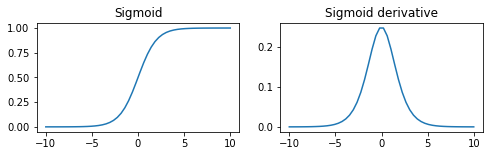

In [29]:
# test sigmoid and it's derivative
test_arr = np.linspace(-10, 10) # Return evenly spaced numbers over a specified interval
# create variable that stores figure
plt.figure(figsize=(8, 2)) 
# first plot
ax1 = plt.subplot(121)
ax1.set_title('Sigmoid')
ax1.plot(test_arr, sigmoid(test_arr))
# second plot
ax2 = plt.subplot(122)
ax2.set_title('Sigmoid derivative')
ax2.plot(test_arr, sigmoid_derivative(test_arr))

plt.show()

## Cross entropy

In [30]:
def categorical_crossentropy(y_pred, y):
    """ y_pred - logits
        y - labels
    """
    # positive part of logical loss
    # y > 0
    pos = -y*np.log(y_pred)
    # negative part of logical loss
    # y < 0
    neg = -(1-y)*np.log(1-y_pred)
    # we sum binary cross entropy loss over every cell in one-hot vector
    # E.g. for 5 classes - 5 error values, that should be summarized
    cost = np.sum(np.nan_to_num(pos+neg), axis=1)
    # we should return mean value over every training sample
    return np.mean(cost)

def categorical_crossentropy_derivative(y_pred, y):
    """ y_pred - logits
        y - labels
    """
    return y_pred-y

Now we should to verify our cost function. To do it we choose 5 label's values from our training set and create an array of length 10, where 5 values is correct and another 5 - zeros.

In [31]:
# test entropy
# array of length ten
test_arr_x = np.zeros(10, dtype=np.int32)
# choose 5 correct labels
test_arr_x[5:] = labels[5:10].copy()
# to categorical
test_arr_x = np.eye(N_CLASSES, dtype='int32')[test_arr_x]
# we add some real values to avoid NaN
test_arr_x = test_arr_x*0.99+0.00001
# to evaluate we choose our true labels
test_arr_z = y_train[:10].copy()
categorical_crossentropy(test_arr_x[:5], test_arr_z[:5])

9.6755577851529093

### Weight initializer

In [32]:
def init_weights(sizes):
    # sizes is a number of neurons per layer
    # first layer is input and dont need any weights
    # np.random.randn - random normal distribution
    b = [np.random.randn(1,y) for y in sizes[1:]]
    # weights
    # sizes[:-1] - every except last
    # sizes[1:] - every except first
    # zip creates generator
    W = [np.random.randn(y, x)/np.sqrt(x) 
            for x, y in zip(sizes[1:], sizes[:-1])]
    
    return (W, b)

To verify our initializator we can print weights

In [33]:
W,b = init_weights([784,10])

print('Weight shapes:', [w.shape for w in W])
print('Bias shapes:', [b_.shape for b_ in b])
print('Bias:')
print(b[0])

Weight shapes: [(784, 10)]
Bias shapes: [(1, 10)]
Bias:
[[ 0.40627422 -0.79427131 -2.4987268   1.1948303   1.42406284 -0.66233307
  -1.79327779 -0.06663006 -0.66061186  0.91397532]]


### Forward pass

In [34]:
def feedprop(x, W, b):
    """Return the output of 
    the network if ``x`` is input.
    W - weights
    b - biases
    
    Return a, z, act
        a - array, predicted value
        zs - list, variable that stores 
            all neuron info for every layer
        acts - list, all activations for every layer
              including input
    """
    a = x
    acts = [a] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer

    for w,b_ in zip(W, b):
        z = np.dot(a, w) + b_
        zs.append(z)
        # apply activation
        a = sigmoid(z)
        acts.append(a)
    y_pred = a
    return y_pred, zs, acts

Test feed forward pass

In [35]:
# test feed forward pass
# create network parameters
W,b = init_weights([784,100,10])
# get predictions
pred = feedprop(X_train, W, b)[0]
print('Prediction shape:', pred.shape)
print('First prediction:', np.argmax(pred[0]))
print('Cost with random weights:', categorical_crossentropy(pred, y_train))

Prediction shape: (42000, 10)
First prediction: 0
Cost with random weights: 12.2411884621


### We need some accuracy metric

In [36]:
def accuracy(x,y,W,b):
    '''x - network inputs
       y - labels
    '''
    y_pred = feedprop(x,W,b)[0]
    y_pred = np.argmax(y_pred, axis=1)
    y = np.argmax(y, axis=1)
    acc = np.equal(y_pred, y)
    acc = np.mean(acc)
    return acc

In [37]:
# test feed forward pass
# create network parameters
W,b = init_weights([784,100,10])
# get predictions
pred = feedprop(X_train, W, b)[0]
print('Prediction shape:', pred.shape)
print('First prediction:', np.argmax(pred[0]))
print('Cost with random weights:', categorical_crossentropy(pred, y_train))
acc = accuracy(X_train, y_train, W, b)
print('Accuracy:', acc)

Prediction shape: (42000, 10)
First prediction: 9
Cost with random weights: 13.6191427977
Accuracy: 0.0578571428571


### Backward pass

In [38]:
def backprop(x, y, W, b):
    '''(x,y) - one learning pair
       W - weights
       b - biases
    '''
    # variables for storing gradients
    grad_b = [np.zeros_like(b_) for b_ in b]
    grad_W = [np.zeros_like(w) for w in W]
    
    # forward pass
    # predicted value, neurons values, activations
    y_pred, zs, acts = feedprop(x, W, b)
    # reshape to matrix
    if len(acts[0].shape) == 1:
        acts[0] = np.expand_dims(acts[0], axis=1)
    # compute error for last layer
    e = categorical_crossentropy_derivative(y_pred, y)
    #e = e*sigmoid_derivative(zs[-1])
    grad_b[-1] = e
    grad_W[-1] = np.dot(acts[-2].T, e) # we dont need last activation
    # loop back over layers
    n_layers = len(b)+1
    for l in range(2, n_layers):
        z = zs[-l]
        # gradient for sigmoid
        sigmoid_grad = sigmoid_derivative(z)
        e = np.dot(e, W[-l+1].T) * sigmoid_grad
        grad_b[-l] = e
        grad_W[-l] = np.dot(acts[-l-1], e)
        
    return grad_W, grad_b

Test backpropagation on first 10 training samples

In [849]:
for x,y in zip(X_train[:10],y_train[:10]):
    grad_W, grad_b = backprop(x, y, W, b)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


### Let's do Gradient Descent

In [868]:
def GD(X_train, y_train, W, b, epochs, learning_rate):
    for i in range(epochs):
        delta_W = [np.zeros_like(w) for w in W]
        delta_b = [np.zeros_like(b_) for b_ in b]
        
        for x,y in zip(X_train, y_train):
            grad_W, grad_b = backprop(x,y,W,b)
            
            for l in range(len(b)):
                # compute delta
                delta_W[l] += grad_W[l]
                delta_b[l] += grad_b[l]
                
        for l in range(len(b)):
            W[l] = W[l] - (learning_rate/len(X_train))*delta_W[l]
            b[l] = b[l] - (learning_rate/len(X_train))*delta_b[l]
                
        # metric
        #print([w.shape for w in W])
        #print([b_.shape for b_ in b])
        
        train_acc = accuracy(X_train, y_train, W, b)
        print('Epoch {} Accuracy: {}'.format(i, train_acc))
    
    return W,b

### Construct neural network (init weights)

In [884]:
W,b = init_weights([X_train.shape[1],30,N_CLASSES])

### Do 50 epochs of gradient descent

In [885]:
W,b = GD(X_train, y_train, W, b, 50, 0.8)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 0 Accuracy: 0.08542857142857142
Epoch 1 Accuracy: 0.1345952380952381
Epoch 2 Accuracy: 0.21723809523809523
Epoch 3 Accuracy: 0.29678571428571426
Epoch 4 Accuracy: 0.35604761904761906
Epoch 5 Accuracy: 0.3887857142857143
Epoch 6 Accuracy: 0.4180238095238095
Epoch 7 Accuracy: 0.4504761904761905
Epoch 8 Accuracy: 0.4855238095238095
Epoch 9 Accuracy: 0.5050714285714286
Epoch 10 Accuracy: 0.5241666666666667
Epoch 11 Accuracy: 0.5490952380952381
Epoch 12 Accuracy: 0.5598095238095238
Epoch 13 Accuracy: 0.5618571428571428
Epoch 14 Accuracy: 0.5806428571428571
Epoch 15 Accuracy: 0.5988809523809524
Epoch 16 Accuracy: 0.6019761904761904
Epoch 17 Accuracy: 0.6240238095238095
Epoch 18 Accuracy: 0.6312619047619048
Epoch 19 Accuracy: 0.6386190476190476
Epoch 20 Accuracy: 0.6586904761904762
Epoch 21 Accuracy: 0.661047619047619
Epoch 22 Accuracy: 0.6806666666666666
Epoch 23 Accuracy: 0.6765238095238095
Epoch 24 Accuracy: 0.6913333333333334
Epoch 25 Accuracy: 0.6931904761904762
Epoch 26 Accuracy: 